# CS 505 Homework 04:  Classification

#### Due Friday  10/27 at midnight (1 minute after 11:59 pm) in Gradescope (with a grace period of 6 hours)
#### You may submit the homework up to 24 hours late (with the same grace period) for a penalty of 10%.

All homeworks will be scored with a maximum of 100 points; point values are given
for individual problems, and if parts of problems do not have point values given, they
will be counted equally toward the total for that problem.

Note: I strongly recommend you work in **Google Colab** (the free version) to complete homeworks in this class; in addition to (probably) being faster than your laptop, all the necessary libraries will already be available to you, and you don't have to hassle with <code>conda</code>, <code>pip</code>, etc. and resolving problems when the install doesn't work. But it is up to you!   You should go through the necessary tutorials listed on the web site concerning Colab and storing files on a Google Drive. And of course, Dr. Google is always ready to help you resolve your problems.

I will post a  "walk-through" video ASAP on my <a href="https://www.youtube.com/channel/UCfSqNB0yh99yuG4p4nzjPOA">Youtube Channel</a>.

#### Submission Instructions

You must complete the homework by editing <b>this notebook</b> and submitting the following two files in Gradescope by the due date and time:

  - A file <code>HW04.ipynb</code> (be sure to select <code>Kernel -> Restart and Run All</code> before you submit, to make sure everything works); and
  - A file <code>HW04.pdf</code> created from the previous.
  
  For best results obtaining a clean PDF file on the Mac, select <code>File -> Print Review</code> from the Jupyter window, then choose <code>File-> Print</code> in your browser and then <code>Save as PDF</code>.  Something  similar should be possible on a Windows machine -- just make sure it is readable and no cell contents have been cut off. Make it easy to grade!
  
The date and time of your submission is the last file you submitted, so if your IPYNB file is submitted on time, but your PDF is late, then your submission is late.

## Collaborators (5 pts)

Describe briefly but precisely

1. Any persons you discussed this homework with and the nature of the discussion;
2. Any online resources you consulted and what information you got from those resources; and
3. Any AI agents (such as chatGPT or CoPilot) or other applications you used to complete the homework, and the nature of the help you received.

A few brief sentences is all that I am looking for here.

I worked with Phillip Tran, Dominic Maglione, and Vineet Raju. I used stack overflow for basic debugging. I used chatGPT once to debug regex.

In [1]:
import math
import numpy as np
from numpy.random import shuffle, seed, choice
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib_inline
# get higher quality plots
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

from torchvision.datasets import MNIST
import torchvision.transforms as T

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

## Problem One: Exploring Shakespeare's Plays with PCA (45 pts)

In this problem, we will use Principal Components Analysis to look at Shakespeare's plays, as
we discussed with a very different play/movie in lecture.  Along the way, we shall use the tokenizer and the TF-IDF vectorizer from `sklearn,`
a common machine learning library.

Note: There is a library for text analysis in Pytorch called `Torchtext`, however, in my view this will less well-developed and less well-supported than the rest of Pytorch, so we shall use `sklearn` for this problem.



### Part A:  Reading and exploring the data (5 pts)

The cells below read in three files and convert them to `numpy` arrays (I prefer to work with the arrays rather than with `pandas` functions, but it is your choice).  

1. The file `shakespeare_plays.csv` contains lines from William Shakespeare’s plays. The second column of the file contains the name of
the play, the third the name of the player (or the indication `<Stage Direction>`, and the fourth
the line spoken:

2. The file `play_attributes.csv` stores the genres and chronology of Shakepeare's plays; the first column is the name of the play, the second the genre, and the third its order in a chronological listing of when it was first performed. The plays are in the same (arbitrary) order as in the first file.



3. The file `player_genders.csv` stores the name of a major character (defined somewhat arbitrarily as one whose total lines contain more than 1400 characters) in the first column and their gender in the second.



**To Do:**   For each of the arrays, print out the the `shape` and the first line.


In [2]:
plays_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/shakespeare_plays.csv').to_numpy()

player_genders_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/player_genders.csv').to_numpy()

play_attributes_array = pd.read_csv('https://www.cs.bu.edu/fac/snyder/cs505/play_attributes.csv').to_numpy()


In [3]:
print(plays_array.shape, plays_array[0])
print(player_genders_array.shape, player_genders_array[0])
print(play_attributes_array.shape, play_attributes_array[0])

(111582, 4) [1 'Henry IV Part 1' '<Stage Direction>' 'ACT I']
(398, 2) ['AARON' 'male']
(36, 3) ['Henry IV Part 1' 'History' 15]


### Part B: Visualizing the Plays (8 pts)

1. Create an array containing 36 strings, each being the concatenation of all lines spoken.   Be sure to NOT include stage directions!  You may wish to create an appropriate dictionary as an intermediate step.

2. Create a document-term matrix where each row represents a play and each column represents a term used in that play. Each entry in this matrix represents the number of times a particular word (defined by the column) occurs in a particular play (defined by the row). Use `CountVectorizer` in `sklearn` to create the matrix. Keep the rows in the same order as in the original files in order to associate play names with terms correctly.

3. From this matrix, use `TruncatedSVD` in `sklearn` to create a 2-dimensional representation of each play. Try to make it as similar as possible to the illustration below, including (i) appropriate title, (ii) names of each play, followed by its chronological order, and (iii) different colors for each genre. Use a `figsize` of `(8,8)` and a `fontsize` of `6` to provide the best visibility. You can follow the tutorial [here](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/) to create the visualization (look at the "PCA" part).

4. Now do the same thing all over again, but with TF-IDF counts (using `TFIDFVectorizer` in `sklearn`).


5. Answer the following in a few sentences:  What plays are similar to each other? Do they match the grouping of Shakespeare’s plays into comedies, histories, and tragedies here?  Which plays are outliers (separated from the others in the same genre)?  Did one of TF or TF-IDF provided the best insights?


# Part 1: Solution

In [4]:
play_lines_dict = defaultdict(list)

for row in plays_array:
  _, play_name, player_name, line = row
  if player_name != "<Stage Direction>":
    play_lines_dict[play_name].append(line)


play_lines = [" ".join(play_lines_dict[play_name])
          for play_name in play_lines_dict.keys()]

# Part 2: Solution

In [5]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(play_lines)

X.shape

(36, 22698)

# Part 3: Solution

Text(0.5, 1.0, 'Shakespeare Plays Visualized with SVD')

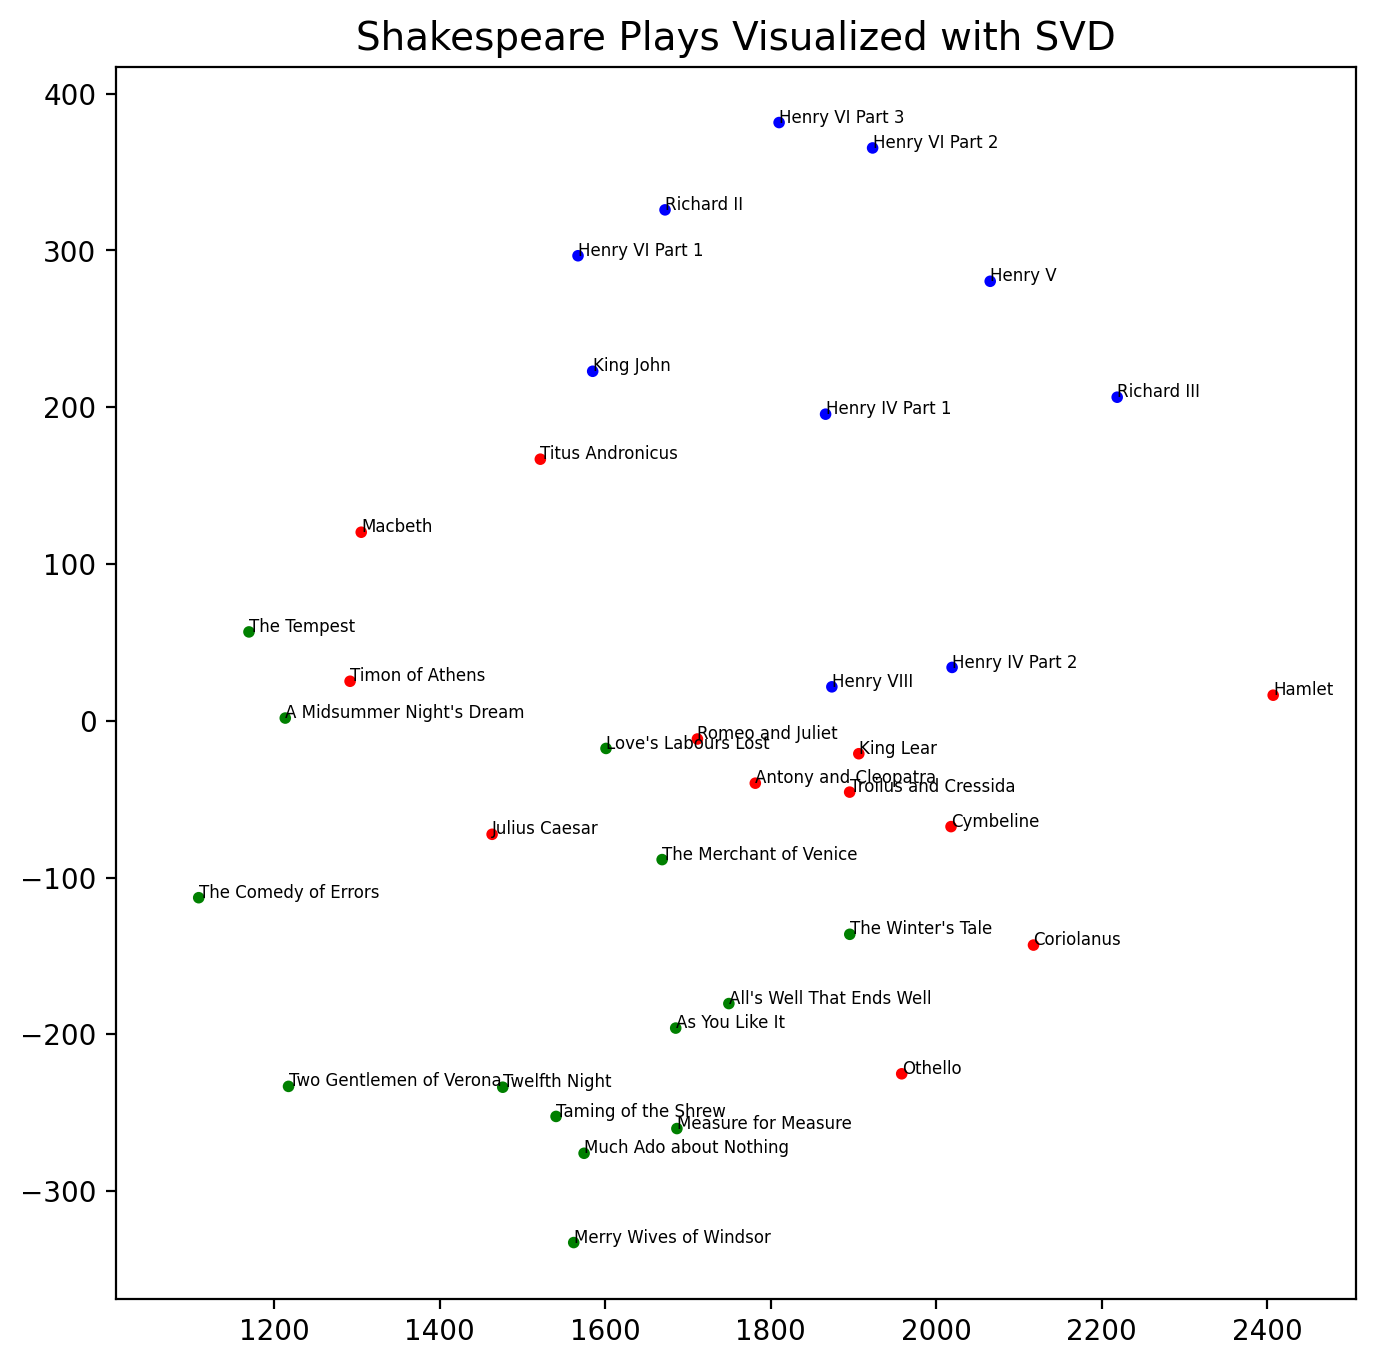

In [6]:
svd = TruncatedSVD(n_components=2, random_state=42)
components = svd.fit_transform(X)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

colors = ["green", "blue", "red"]
categories = np.unique(play_attributes_array[:, 1])
cmap = dict(list(zip(categories, colors)))
c = [cmap[cat] for cat in play_attributes_array[:, 1]]

ax.scatter(components[:, 0], components[:, 1], c=c, s=10)

ax.set_xlim(components[:, 0].min() - 100,
            components[:, 0].max() + 100)

for idx, play_name in enumerate(play_attributes_array[:, 0]):
  ax.annotate(play_name, xy=(components[idx, 0],
                             components[idx, 1]), fontsize=6)

ax.set_title("Shakespeare Plays Visualized with SVD", fontsize=14)

# Part 4: Solution

Text(0.5, 1.0, 'Shakespeare Plays Visualized with SVD')

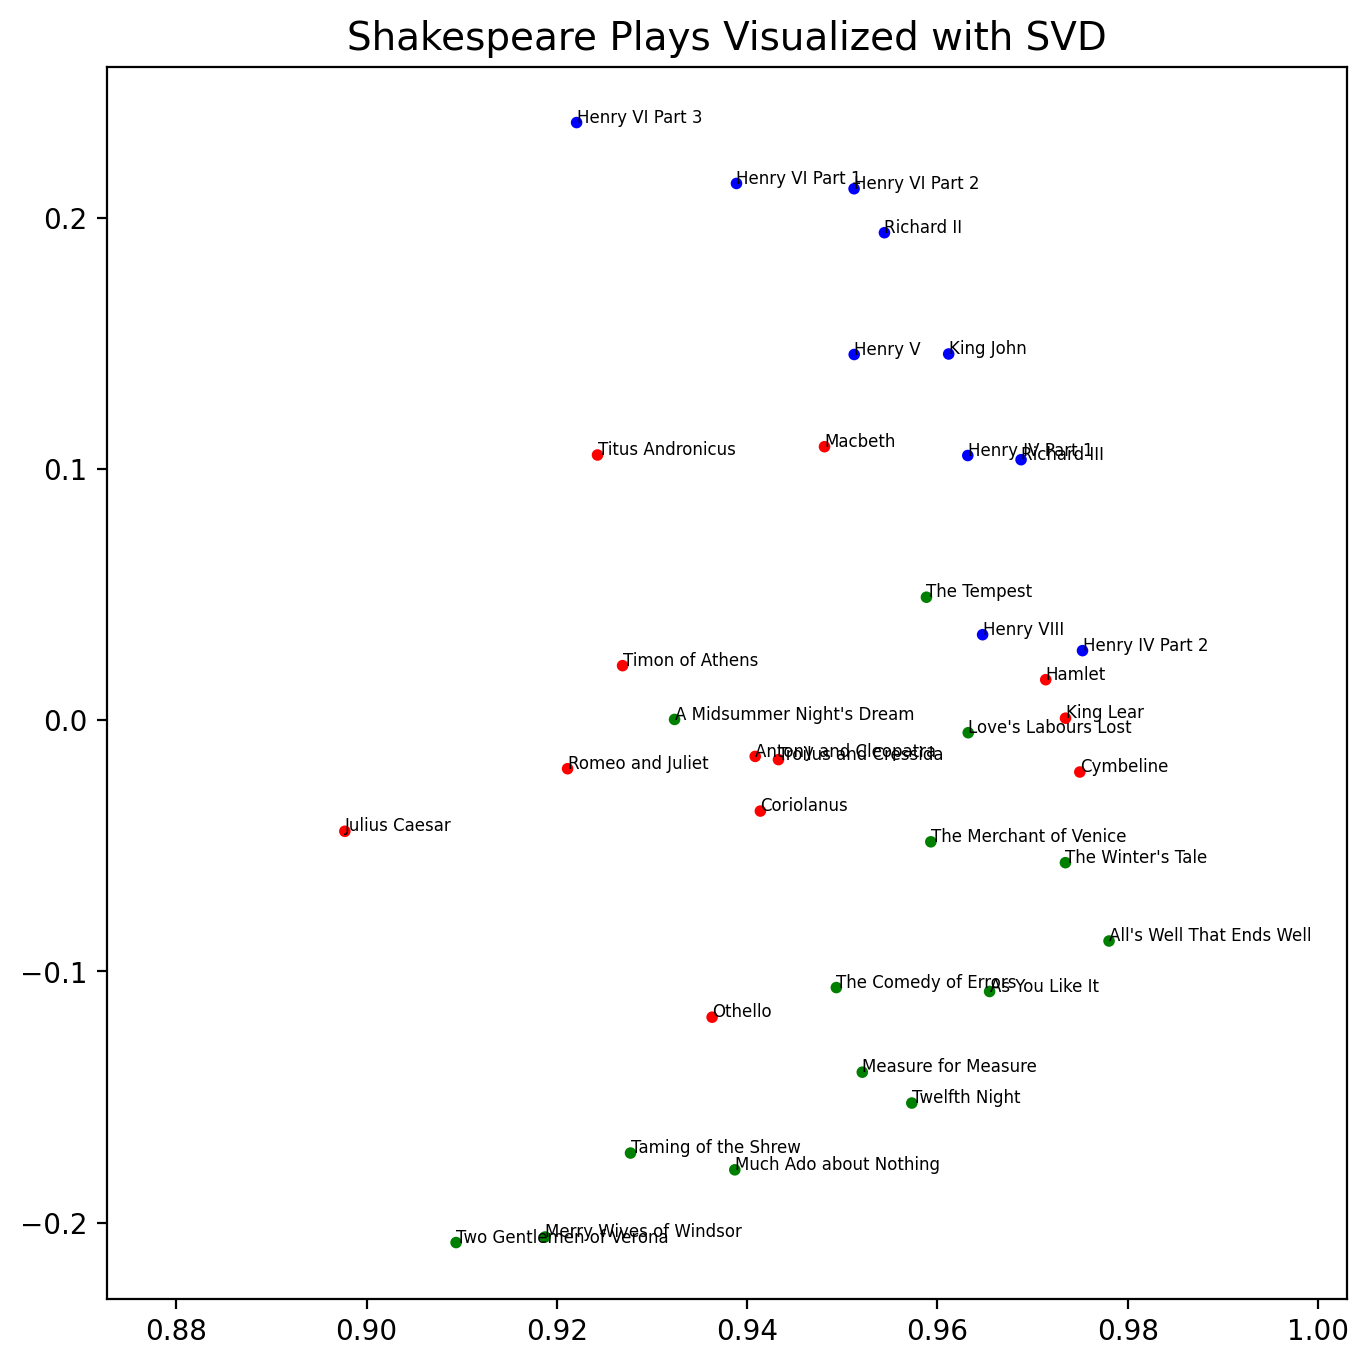

In [7]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(play_lines)

svd_tfidf = TruncatedSVD(n_components=2, random_state=42)
components_tfidf = svd_tfidf.fit_transform(X_tfidf)

fig_2 = plt.figure(figsize=(8, 8))
ax_2 = fig_2.add_subplot(111)

ax_2.scatter(components_tfidf[:, 0], components_tfidf[:, 1],
             c=c, s=10)

ax_2.set_xlim(components_tfidf[:, 0].min() - 0.025,
            components_tfidf[:, 0].max() + 0.025)

for idx, play_name in enumerate(play_attributes_array[:, 0]):
  ax_2.annotate(play_name, xy=(components_tfidf[idx, 0],
                               components_tfidf[idx, 1]),
                               fontsize=6)

ax_2.set_title("Shakespeare Plays Visualized with SVD", fontsize=14)

# Part 5: Solution

Plays with multiple parts are the most similar. For example, the *Henry* plays are closely clustered. The TF and TF-IDF vectorizers are able to generally separate the three categories, although they are both far from perfect. *Henry VIII* and *Henry IV Part 2* are some outliers. In this case, I would give the slight edge to TF since it yields larger inter-cluster distances.

### Part C: Visualizing the Players (8 pts)

Now you must repeat this same kind of visualization, but instead of visualizing plays, you must visualize players.
The process will be essentially the same, starting with an array of strings representing the lines spoken by each player. Use one of TF or TF-IDF, and use different colors for the genders.

Use a figsize of (8,8) and a fontsize of 4 to make this a bit more visible.

Again, comment on what you observe (it will not be as satisfying as the previous part).

Text(0.5, 1.0, 'Shakespeare Players Visualized with SVD')

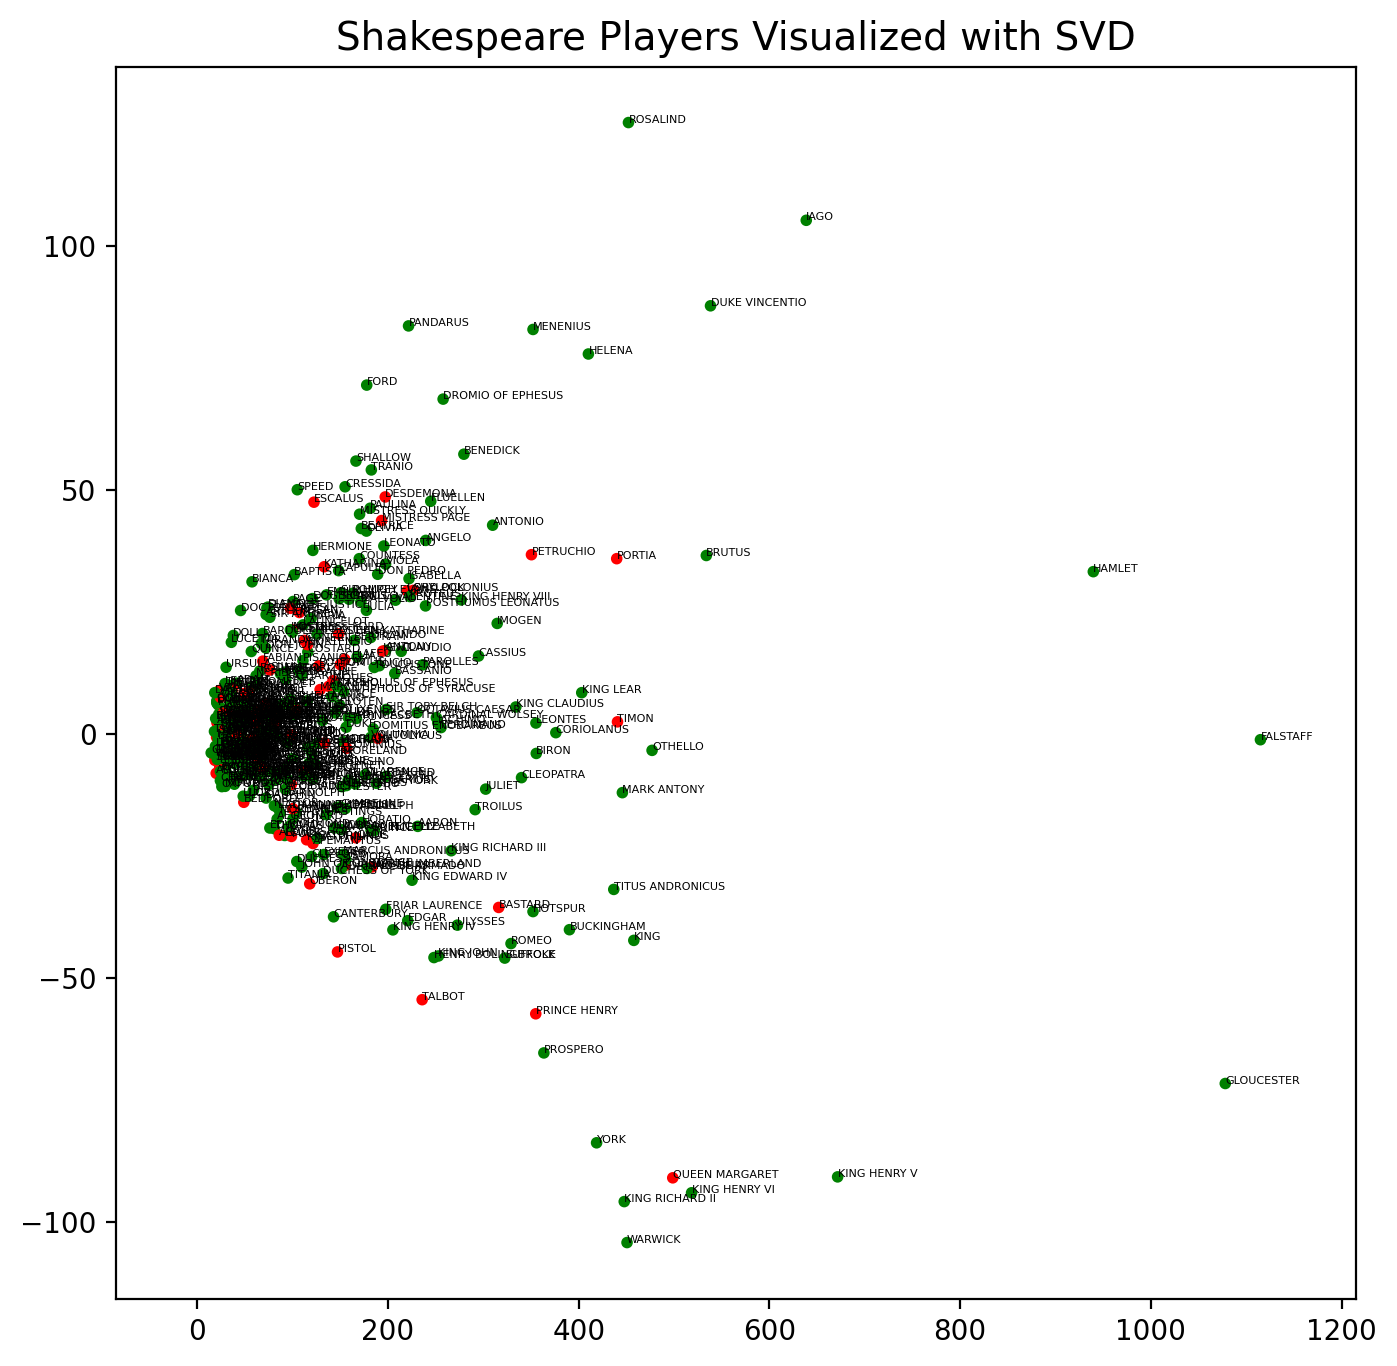

In [8]:
player_lines_dict = defaultdict(list)

player_names = set(player_genders_array[:, 0])

for row in plays_array:
  _, play_name, player_name, line = row
  if player_name != "<Stage Direction>" and player_name in player_names:
    player_lines_dict[player_name].append(line)

player_lines = [" ".join(player_lines_dict[player_name])
                for player_name in player_lines_dict.keys()]

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(player_lines)

svd = TruncatedSVD(n_components=2, random_state=42)
components = svd.fit_transform(X)

fig_3 = plt.figure(figsize=(8, 8))
ax_3 = fig_3.add_subplot(111)

genders = player_genders_array[:, 1]
cmap = {"male": "green", "female": "red"}
c = [cmap[g] for g in genders]

ax_3.scatter(components[:, 0], components[:, 1], s=10, c=c)

ax_3.set_xlim(components[:, 0].min() - 100,
              components[:, 0].max() + 100)

for idx, player_name in enumerate(player_lines_dict.keys()):
  ax_3.annotate(player_name, xy=(components[idx, 0],
                                 components[idx, 1]), fontsize=4)

ax_3.set_title("Shakespeare Players Visualized with SVD", fontsize=14)

Using TF vectorization and dimensionality reduction does not well separate the different players. There is noticeably one large cluster that does not provide any insight into the relationships between players. Outside of the main cluster we do see some players grouped together.

### Part D:  DIY Word Embeddings (8 pts)

In this part you will create a word-word matrix where each row (and each column) represents a word in the vocabulary.
Each entry in this matrix represents the number of times a particular word (defined by the row) co-occurs with another
word (defined by the column) in a sentence (i.e., line in `plays`). Using the row word vectors, create a document-term matrix which represents
a play as the average of all the word vectors in the play.

Display the plays using `TruncatedSVD` as you did previously.  

Again, comment on what you observe: how different is this from the first visualization?

**Notes:**  

1. Remove punctuation marks .  ,  ;  :  ?  ! but leave single quotes.
2. One way to proceed is to create a nested dictionary mapping each word to a dictionary of the frequency of words that occur in the same line, then from this to create the sparse matrix which is used to create the aerage document-term matrix which is input to `TruncatedSVD`.
3. If you have trouble with the amount of memory necessary, you may wish to eliminate "stop words" and then isolate some number (say, 5000) of the remaining most common words, and build your visualization on that instead of the complete vocabulary.


In [9]:
pattern = re.compile(r"[.,;:?!]")
corpus = defaultdict(list)

for play_name, sentences in play_lines_dict.items():
  for sentence in sentences:
    cleaned_sentence = re.sub(pattern=pattern, repl="",
                              string=sentence.lower())
    corpus[play_name].append(cleaned_sentence)

In [10]:
word_to_word = defaultdict(lambda: defaultdict(int))
vocab = set()

for play_name in corpus.keys():
  for sentence in corpus[play_name]:
    words = sentence.split()
    for i, current_word in enumerate(words):
      if current_word not in vocab:
        vocab.add(current_word)
      for j, word in enumerate(words):
        if i == j:
          continue
        word_to_word[current_word][word] += 1

In [11]:
vocab_ids = dict(list(zip(vocab, range(len(vocab)))))

In [12]:
from scipy.sparse import csr_matrix

data = []
row_ind = []
col_ind = []

for curr_word, co_occurring_dict in word_to_word.items():
    r_ind = vocab_ids[curr_word]
    for word, freq in co_occurring_dict.items():
      c_ind = vocab_ids[word]
      row_ind.append(r_ind)
      col_ind.append(c_ind)
      data.append(freq)

embedding_matrix = csr_matrix((data, (row_ind, col_ind)),
                              shape=(len(vocab_ids), len(vocab_ids)))

In [13]:
document_matrix = np.zeros(shape=(len(corpus),
                                  len(vocab)))

for idx, play_name in enumerate(corpus.keys()):
  num_words = 0
  for sentence in corpus[play_name]:
    words = sentence.split()

    r_ind = [vocab_ids[w] for w in words]

    num_words += len(r_ind)

    document_matrix[idx] += embedding_matrix[r_ind] \
                                            .toarray().sum(axis=0)

  document_matrix[idx] /= num_words

Text(0.5, 1.0, 'Shakespeare Co-occurences with SVD')

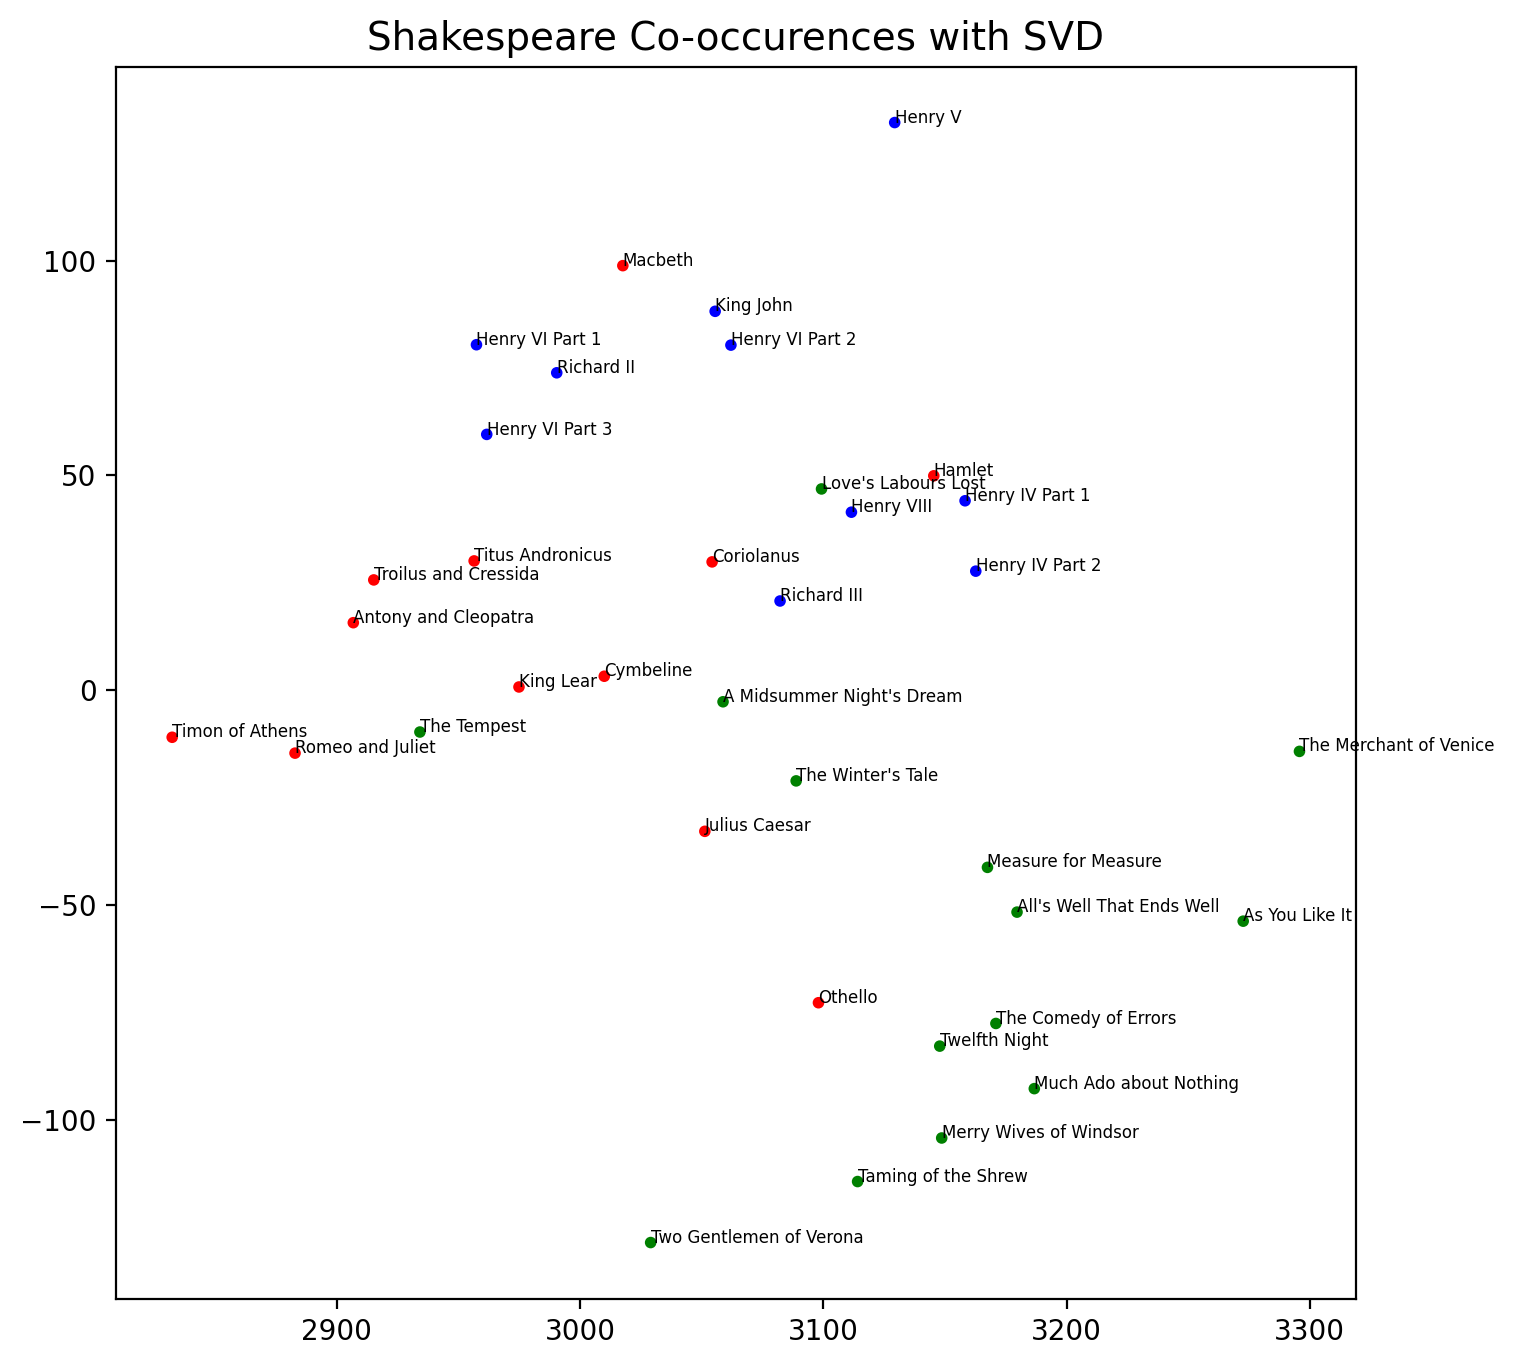

In [14]:
svd = TruncatedSVD(n_components=2, random_state=42)
components = svd.fit_transform(document_matrix)

fig_4 = plt.figure(figsize=(8, 8))
ax_4 = fig_4.add_subplot(111)

cmap = dict(list(zip(categories, colors)))
c = [cmap[cat] for cat in play_attributes_array[:, 1]]
ax_4.scatter(components[:, 0], components[:, 1], s=10, c=c)

for idx, play_name in enumerate(play_attributes_array[:, 0]):
  ax_4.annotate(play_name, xy=(components[idx, 0],
                               components[idx, 1]),
                               fontsize=6)

ax_4.set_title("Shakespeare Co-occurences with SVD", fontsize=14)

The clusters are in relatively the same locations as the first visualization, however, the DIY embeddings visualization seems to do a better job of grouping similar categories in clusters. This might be since the embeddings capture greater context about the types of words and their co-occurences in each play.

### Part E:  Visualizing the Plays using Word2Vec Word Embeddings (8 pts)

Now we will do the play visualization using word embeddings created by Gensim's `Word2Vec`, which can create word embeddings just as you did in the previous part, but using better algorithms.

You can read about how to use `Word2Vec` and get template code here:

https://radimrehurek.com/gensim/models/word2vec.html

I strongly recommend you follow the directions for creating the model, then using `KeyedVectors` to
avoid recomputing the model each time.

Experiment with the `window` (say 5) and the `min_count` (try in the range 1 - 5) parameters to get the best results.

Display the plays using `PCA` instead of `TruncatedSVD`.  

Again, comment on what you observe: how different is this from the other visualizations?


In [15]:
from gensim.models import Word2Vec
from tqdm import tqdm
from pathlib import Path

In [16]:
text = [sentence.split() for play_name in corpus.keys()
        for sentence in corpus[play_name]]

trials = 10

rng = np.random.default_rng(seed=42)

windows = rng.integers(1, 6, size=trials)
min_counts = rng.integers(1, 6, size=trials)

# randomized search
hyperparams = {"window": windows,
               "min_count": min_counts}
vector_size = 100

save_path = Path("./plays_w2v")

save_path.mkdir(exist_ok=True)

for w, m in tqdm(zip(windows, min_counts), total=trials):
  model = Word2Vec(sentences=text, vector_size=vector_size,
                   window=w, min_count=m, epochs=5,
                   workers=2)
  model.save(str(save_path.joinpath(f"{w}_{m}.model")))

100%|██████████| 10/10 [00:49<00:00,  4.96s/it]


In [17]:
model_params = []

model_paths = list(save_path.glob("*.model"))

w2v_matrix = np.zeros(shape=(len(model_paths), len(corpus),
                             vector_size))

for t, model_fname in enumerate(tqdm(model_paths)):
  window_size, min_count = model_fname.stem.split("_")[-2:]
  model_params.append((window_size, min_count))

  model = Word2Vec.load(str(model_fname))

  for idx, play_name in enumerate(corpus.keys()):
    num_words = 0

    for sentence in corpus[play_name]:
      words = sentence.split()

      for word in words:
        if word in model.wv:
          w2v_matrix[t][idx] += model.wv[word]
          num_words += 1

    w2v_matrix[t][idx] /= num_words

100%|██████████| 7/7 [00:25<00:00,  3.66s/it]


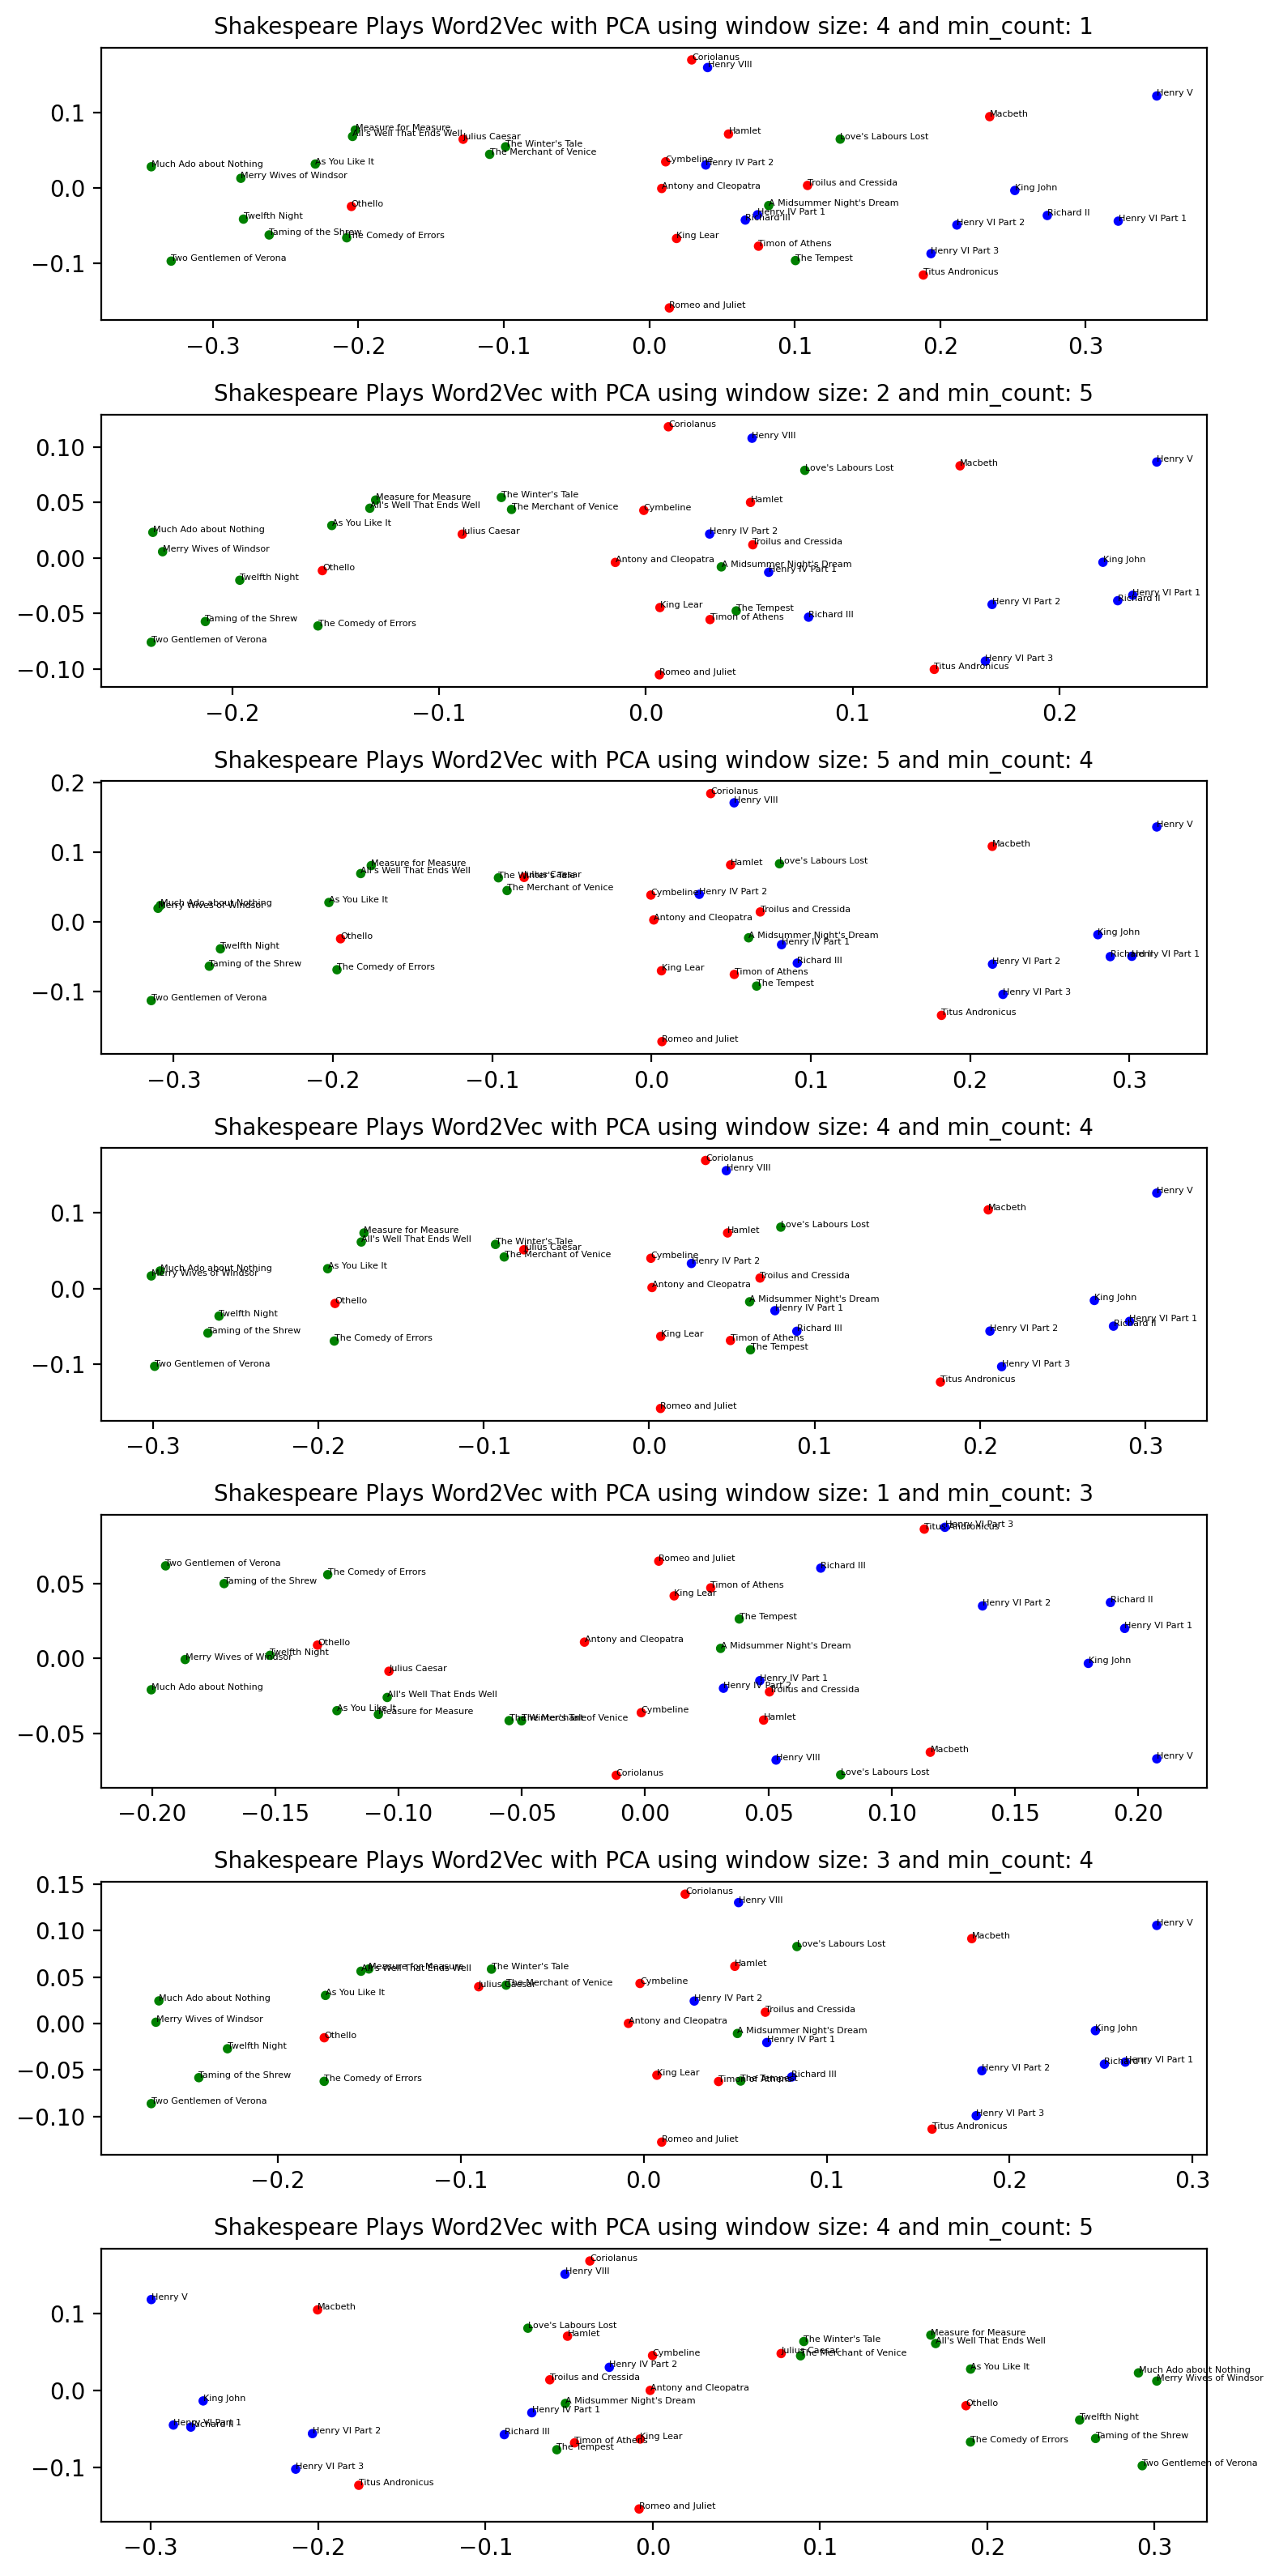

In [18]:
fig, axs = plt.subplots(len(model_paths), 1,
                        figsize=(8, 16), tight_layout=True)

pca = PCA(n_components=2, random_state=42)

for t in range(len(model_paths)):
  components = pca.fit_transform(w2v_matrix[t])

  cmap = dict(list(zip(categories, colors)))
  c = [cmap[cat] for cat in play_attributes_array[:, 1]]
  axs[t].scatter(components[:, 0], components[:, 1], s=10, c=c)

  for idx, play_name in enumerate(play_attributes_array[:, 0]):
    axs[t].annotate(play_name, xy=(components[idx, 0],
                                components[idx, 1]),
                                fontsize=4)

  window_size, min_count = model_params[t]

  axs[t].set_title(f"Shakespeare Plays Word2Vec with PCA using \
window size: {window_size} and min_count: {min_count}""", fontsize=10)

Based off experimentation, following a randomized search for a set of locally optimal parameters for `window` and `min_count`, I found that there was no clear winner in terms of these hyperparameters. All the trials provide a reasonable clustering of the data, although it is still very noisy with overlapping clusters. I wouldn't consider this the best results. It is interesting that depending on the hyperparameters, the location of the green and blue clusters change, while the red cluster remains in the middle. Perhaps removing stop words and implementing additional normalization of the text would provide more conclusive results.

### Part F:  Visualizing the Players using Word2Vec Word Embeddings (8 pts)

Now you must repeat Part C, but using these `Word2Vec` embeddings.

Use a figsize of (8,8) and a fontsize of 4 to make this a bit more visible.

Again, comment on what you observe. How is this different from what you saw in Part C?


In [19]:
player_lines_dict = defaultdict(list)

for row in plays_array:
  _, play_name, player_name, line = row
  if player_name != "<Stage Direction>" and player_name in player_names:
    cleaned_sentence = re.sub(pattern=pattern, repl="",
                              string=line.lower())
    player_lines_dict[player_name].extend(cleaned_sentence.split())

In [20]:
text = list(player_lines_dict.values())
trials = 10

windows = rng.integers(1, 6, size=trials)
min_counts = rng.integers(1, 6, size=trials)

# randomized search
hyperparams = {"window": windows,
               "min_count": min_counts}
vector_size = 100

save_path = Path("./players_w2v")

save_path.mkdir(exist_ok=True)

for w, m in tqdm(zip(windows, min_counts), total=trials):
  model = Word2Vec(sentences=text, vector_size=vector_size,
                   window=w, min_count=m, epochs=5,
                   workers=2)
  model.save(str(save_path.joinpath(f"{w}_{m}.model")))

100%|██████████| 10/10 [00:38<00:00,  3.89s/it]


In [21]:
model_params = []

model_paths = list(save_path.glob("*.model"))

w2v_matrix = np.zeros(shape=(len(model_paths), len(player_lines_dict),
                             vector_size))

for t, model_fname in enumerate(tqdm(model_paths)):
  window_size, min_count = model_fname.stem.split("_")[-2:]
  model_params.append((window_size, min_count))

  model = Word2Vec.load(str(model_fname))

  for idx, player_name in enumerate(player_lines_dict.keys()):
    num_words = 0

    for sentence in player_lines_dict[player_name]:
      for word in sentence:
        if word in model.wv:
          w2v_matrix[t][idx] += model.wv[word]
          num_words += 1

    w2v_matrix[t][idx] /= num_words

100%|██████████| 10/10 [01:34<00:00,  9.45s/it]


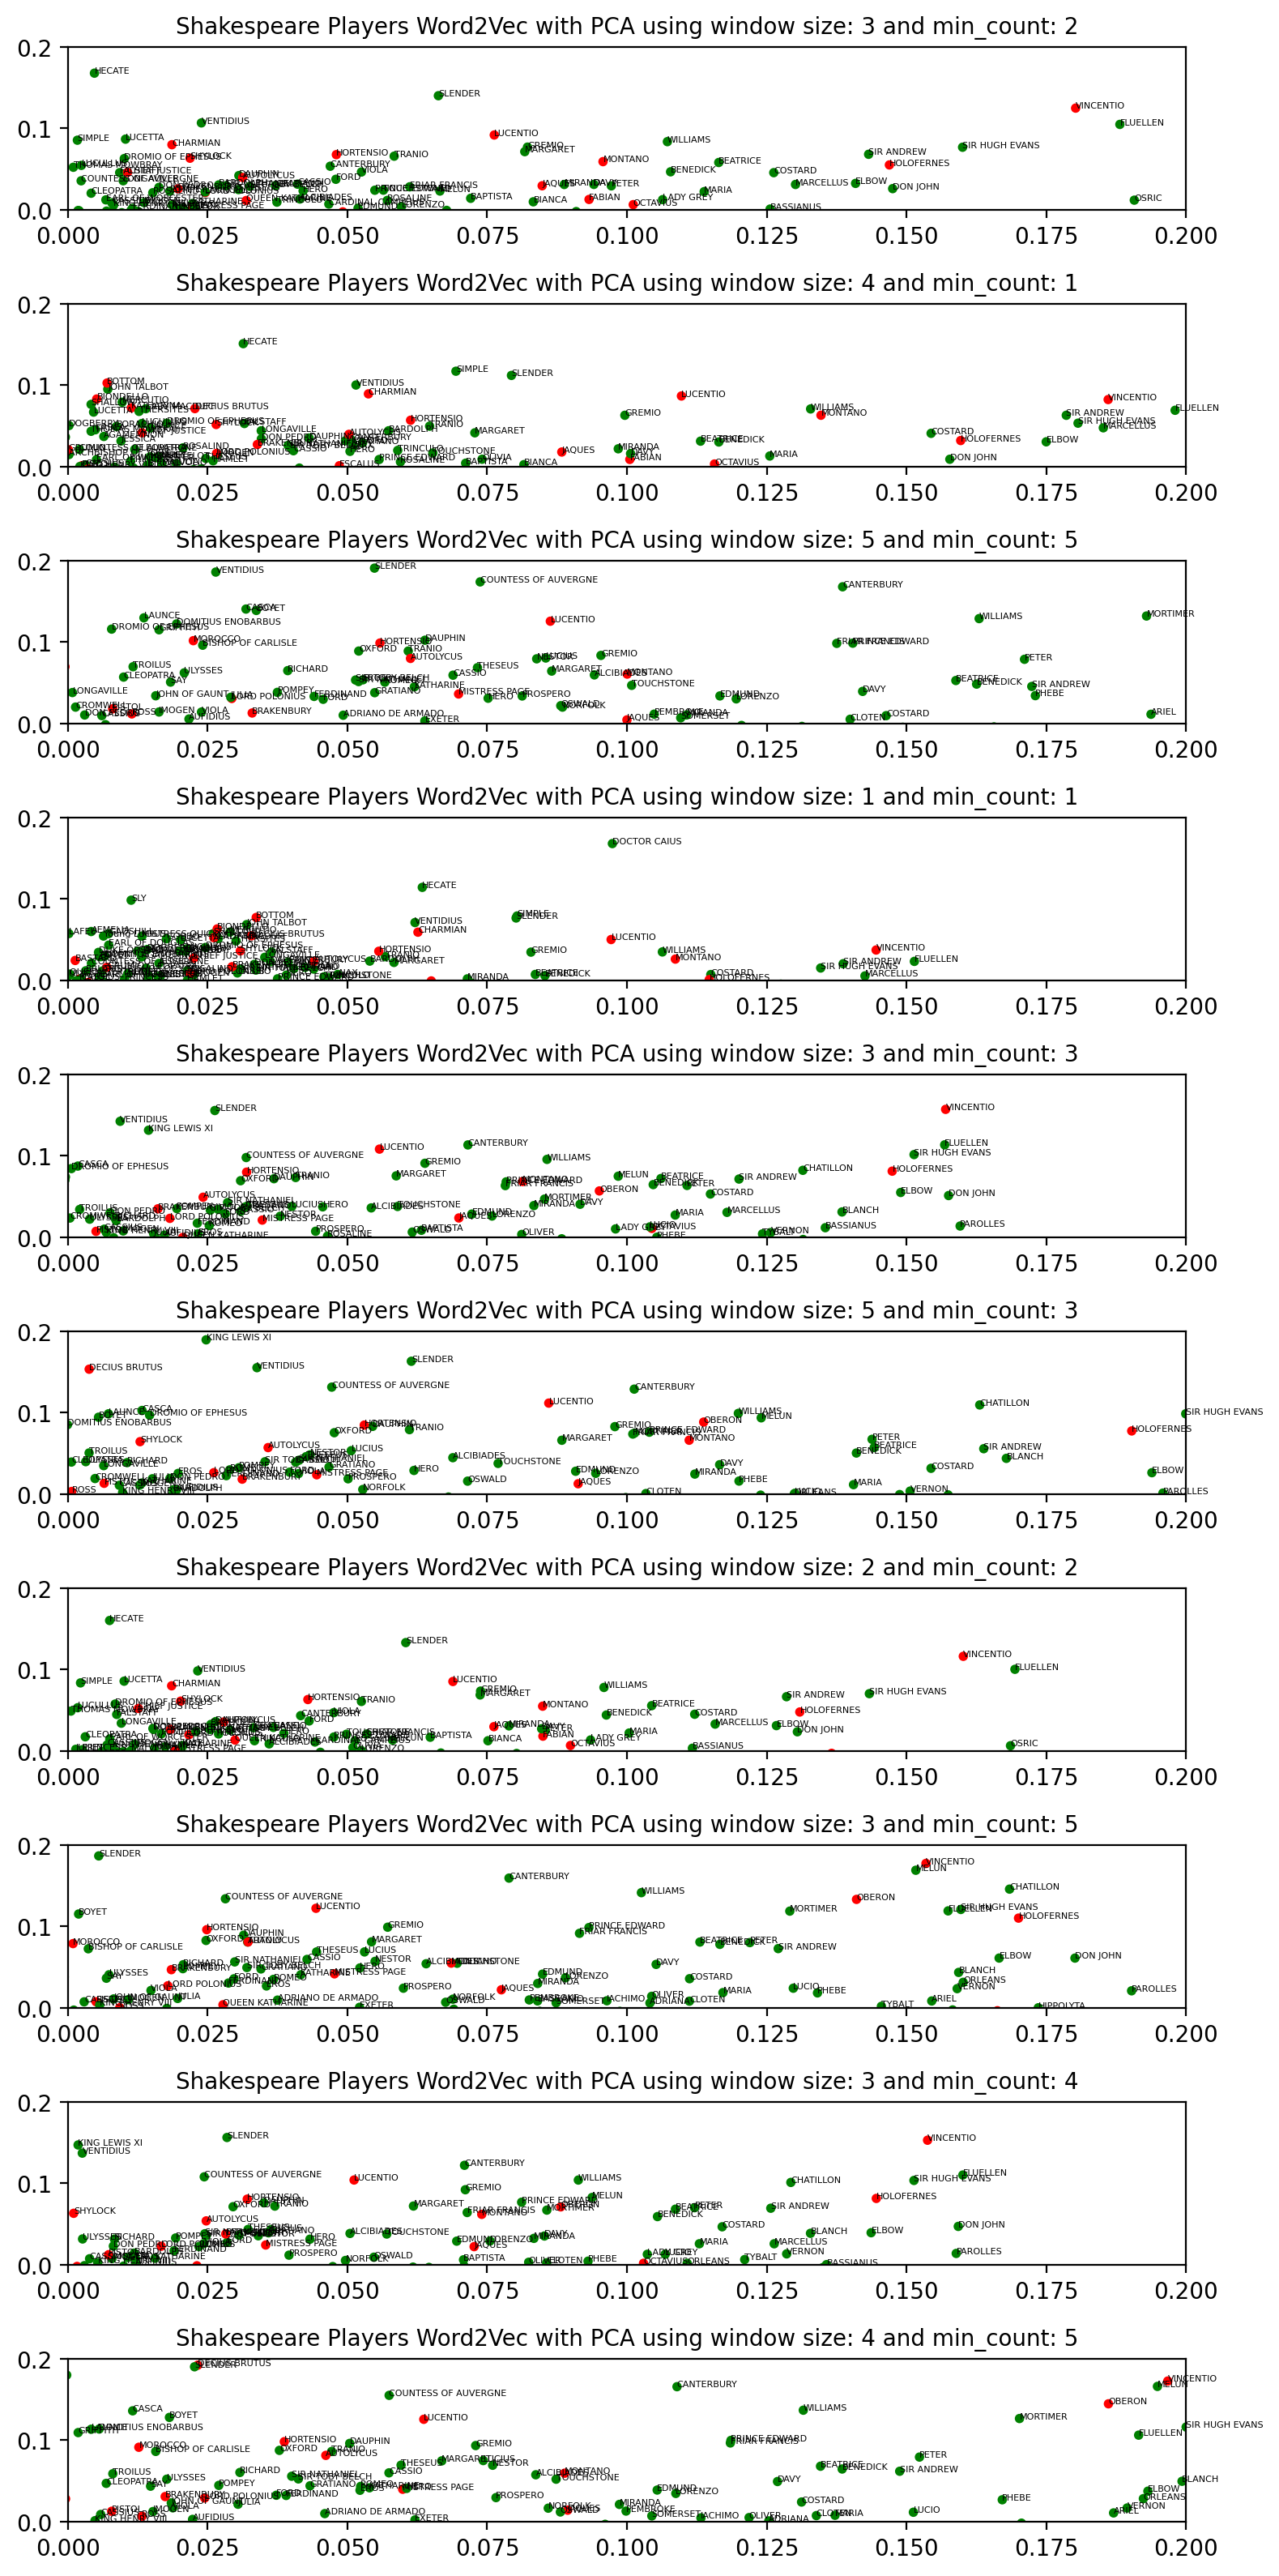

In [22]:
fig, axs = plt.subplots(len(model_paths), 1,
                        figsize=(8, 16), tight_layout=True)

cmap = {"male": "green", "female": "red"}
c = [cmap[g] for g in genders]

for t in range(len(model_paths)):
  components = pca.fit_transform(w2v_matrix[t])

  axs[t].scatter(components[:, 0], components[:, 1], s=10, c=c)
  axs[t].set_xlim(0, 0.2)
  axs[t].set_ylim(0, 0.2)


  for idx, player_name in enumerate(player_lines_dict.keys()):
    axs[t].annotate(player_name, xy=(components[idx, 0],
                                  components[idx, 1]), fontsize=4)

    window_size, min_count = model_params[t]

    axs[t].set_title(f"Shakespeare Players Word2Vec with PCA using \
window size: {window_size} and min_count: {min_count}""", fontsize=10)

Based off experimentation, following a randomized search for a set of locally optimal parameters for `window` and `min_count`, I found that there was no clear winner in terms of these hyperparameters. There seems to be a large cluster forming in the left to middle side of the visuals with some outliers. There is still a lot of noise in the clusters. I also wouldn't consider this the best results. I hypothesize that removing stop words and implementing additional normalization of the text would provide more conclusive results.

## Problem Two: Classifying Text with a Feed-Forward Neural Network (50 pts)


In this problem, you must create a FFNN in Pytorch to classify emails from the Enron dataset as to whether they
are spam or not spam ("ham"). For this problem, we will use `Glove` pretrained embeddings. The dataset
and the embeddings are in the following location:

https://drive.google.com/drive/folders/1cHR4VJuuN2tEpSkT3bOaGkOJrvIV-lSR?usp=sharing

(You can also download the embeddings yourself from the web; but the dataset is one created
just for this problem.)

### Part A: Prepare the Data (10 pts)

Compute the features of the emails (the vector of 100 floats input to the NN) vector based on the average value of the word vectors that belong to the words in it.

Just like the previous problem, we compute the 'representation' of each message, i.e. the vector, by averaging word vectors; but this time, we are using [Glove word embeddings](https://nlp.stanford.edu/projects/glove/) instead. Specifically, we are using word embedding 'glove.6B.100d' to obtain word vectors of each message, as long as the word is in the 'glove.6B.100d' embedding space.

Here are the steps to follow:

1. Have a [basic idea](https://nlp.stanford.edu/pubs/glove.pdf) of how Glove provides pre-trained word embeddings (vectors).
2. Download and extract word vectors from 'glove.6B.100d'.
3. Tokenize the messages ( `spacy` is a good choice) and compute the message vectors by averaging the vectors of words in the message. You will need to test if a word is in the model (e.g., something like ` if str(word) in glove_model ...`) and ignore any words which have no embeddings.


### Part B: Create the DataLoader (15 pts)

Now you must separate the data set into training, validation, and testing sets, and build a 'Dataset' and 'DataLoader' for each that can feed data to train your model with Pytorch.

Use a train-validation-test split of 80%-10%-10%. You can experiment with different batch sizes, starting with 64.



Hints:
1. Make sure `__init__` , `__len__` and `__getitem__` of the your defined dataset are implemented properly. In particular, the `__getitem__` should return the specified message vector and its label.
2. Don't compute the message vector when calling the `__getitem__` function, otherwise the training process will slow down A LOT. Calculate these in an array before creating the data loader in the next step.
3. The data in the `.csv` is randomized, so you don't need to shuffle when doing the split.

# Part A: Solution

In [23]:
from google.colab import drive
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
from typing import List, Dict, Tuple, Optional
from spacy.tokenizer import Tokenizer
import spacy
from pathlib import Path
from tqdm import tqdm, trange
import time
import matplotlib.pyplot as plt

drive.mount("/content/drive")

Mounted at /content/drive


In [24]:
DATA_DIR = Path("/content/drive/MyDrive/CS505/HW04")

In [25]:
!ls $DATA_DIR

enron_spam_ham.csv  glove.6B.100d.txt  HW04.ipynb  HW04.pdf


In [26]:
embedding_table = dict()

with open(DATA_DIR/"glove.6B.100d.txt") as f:
  for line in f.readlines():
    content = line.split()
    word, embedding = content[0], content[1:]
    embedding = np.array(embedding, dtype=np.float64)
    embedding_table[word] = embedding

In [56]:
len(embedding_table)

400000

In [57]:
nlp = spacy.load("en_core_web_sm")

In [58]:
df = pd.read_csv(DATA_DIR/"enron_spam_ham.csv")

In [59]:
df.head()

,Message,Spam
0,"Subject: sevil yamin anne , vasant sent this...",0
1,"Subject: all graphics software available , che...",1
2,Subject: turbine position report 9 / 21 / 01 ...,0
3,Subject: tim belden ' s new cell number my ol...,0
4,"Subject: producer one press advisory louise ,...",0


In [74]:
def create_dataset(df: pd.DataFrame, nlp: spacy.language.Language,
                   embedding_table: Dict[str, np.ndarray],
                   embedding_dim: int = 100,
                   tokenizer_bs: int = 256) -> Tuple[np.ndarray, np.ndarray]:

    messages = df["Message"].tolist()

    X = np.zeros(shape=(len(messages), embedding_dim))

    for idx, doc in enumerate(tqdm(nlp.tokenizer.pipe(
                                    messages,
                                    batch_size=tokenizer_bs),
                                    total=len(messages))):
      n = 0
      for token in doc:
        word = token.text
        if word in embedding_table:
          X[idx] += embedding_table[word]
          n += 1

      X[idx] /= n

    y = df["Spam"].to_numpy().reshape(-1, 1)

    return X, y


def split_data(X: np.ndarray, y: np.ndarray, train_frac: float,
               val_frac: float) -> Tuple[np.ndarray, ...]:

  dataset_size = X.shape[0]

  indices = np.arange(dataset_size)

  np.random.shuffle(indices)

  train_idx = int(dataset_size * train_frac)
  val_idx = train_idx + int(dataset_size * val_frac)

  X_train, y_train = X[indices[:train_idx]], y[indices[:train_idx]]
  X_val, y_val = X[indices[train_idx: val_idx]], y[indices[train_idx: val_idx]]
  X_test, y_test = X[indices[val_idx:]], y[indices[val_idx:]]

  return X_train, X_val, X_test, y_train, y_val, y_test


class SpamDataset(Dataset):
  def __init__(self, X: np.ndarray, y: np.ndarray) -> None:
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32)


  def __len__(self) -> int:
    return self.X.shape[0]


  def __getitem__(self, index: int) -> torch.Tensor:
    return self.X[index], self.y[index]

In [76]:
X, y = create_dataset(df=df, nlp=nlp, embedding_table=embedding_table)

100%|██████████| 28138/28138 [00:49<00:00, 569.99it/s]


In [77]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y,
                                                            train_frac=0.8,
                                                            val_frac=0.1)

In [78]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((22510, 100), (2813, 100), (2815, 100), (22510, 1), (2813, 1), (2815, 1))

Text(0.5, 1.0, 'Count of Ham (0) vs Spam (1)')

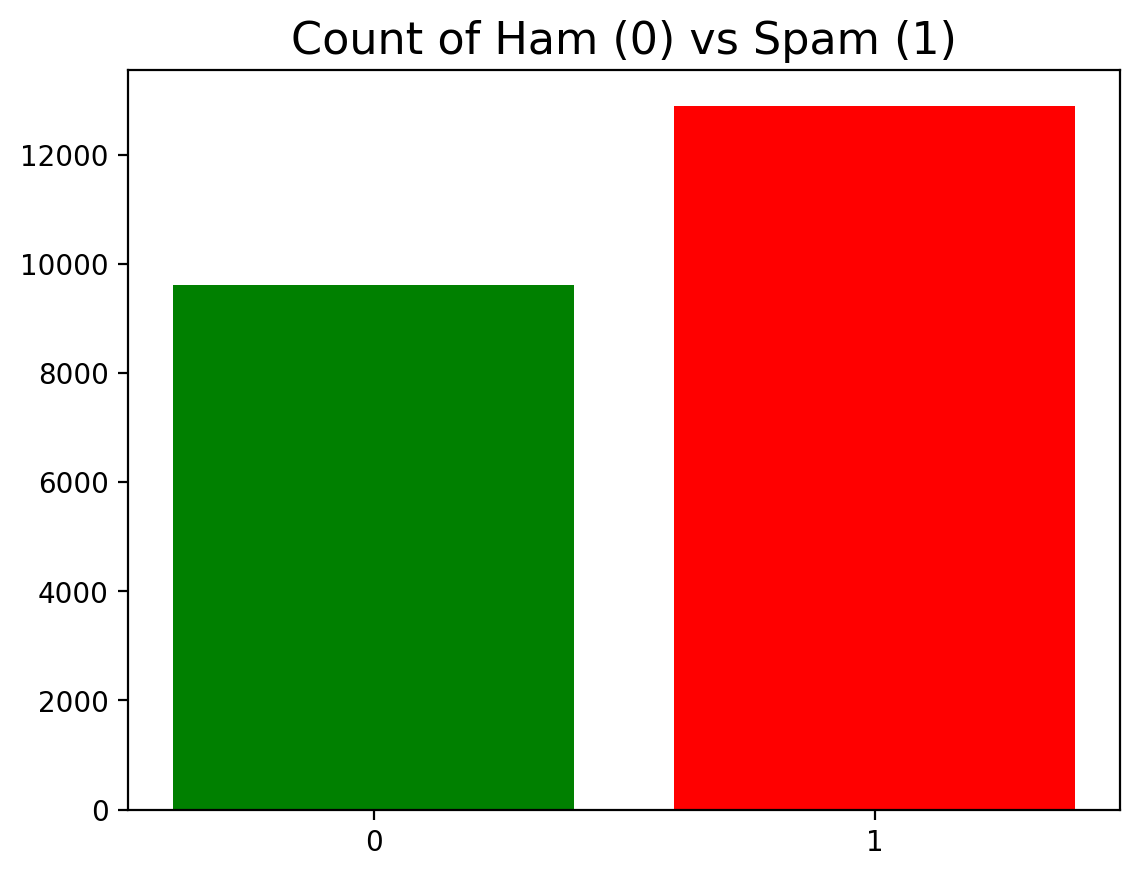

In [79]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.bar([0, 1], np.unique(y_train, return_counts=True)[1], color=["g", "r"])
ax.set_xticks([0, 1])

ax.set_title("Count of Ham (0) vs Spam (1)", fontsize=16)

In [80]:
train_dataset = SpamDataset(X_train, y_train)

val_dataset = SpamDataset(X_val, y_val)

test_dataset = SpamDataset(X_test, y_test)

In [81]:
bs = 64
train_dataloader = DataLoader(train_dataset, batch_size=bs)
val_dataloader = DataLoader(val_dataset, batch_size=bs)
test_dataloader = DataLoader(test_dataset, batch_size=bs)

### Part C:  Build the neural net model (25 pts)

Once the data is ready, we need to design and implement our neural network model.

The model does not need to be complicated. An example structure could be:

1. linear layer 100 x 15
2. ReLU activation layer
3. linear layer 15 x 2

But feel free to test out other possible combinations of linear layers & activation function and whether they make significant difference to the model performance later.

In order to perform "early stopping," you must keep track of the best validation score as you go through the epochs, and
save the best model generated so far; then use the model which existed when the validation score
was at a minimum to do the testing. (This could also be the model which is deployed, although we won't
worry about that.) Read about `torch.save(...)` and `torch.load(...)` to do this.

Experiment with different batch sizes and optimizers and learning rates to get the best validation
score for the model you create with early stopping. (Try not to look *too hard* at the final accuracy!) Include your final performance charts (using `show_performance_curves`) when you submit.

Conclude with a brief analysis (a couple of sentences is fine) relating what experiments you did,
and what choices of geometry, optimizer, learning rate, and batch size gave you the best results.
It should not be hard to get well above 90% accuracy on the final test.

In [83]:
class FFN(nn.Module):
  def __init__(self, embedding_dim: int = 100) -> None:
    super().__init__()
    self.fc1 = nn.Linear(in_features=embedding_dim, out_features=16)
    self.fc2 = nn.Linear(in_features=16, out_features=2)
    self.fc3 = nn.Linear(in_features=2, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

In [84]:
model = FFN(embedding_dim=100).cuda()

In [85]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=[0.9, 0.999])

In [86]:
def train(num_epochs: int,
          early_stopping: bool = True,
          save_model_dir: Optional[str] = None,
          patience: int = 3) -> Dict[str, List[float]]:

  best_epoch_idx = 0
  p = 0

  if save_model_dir:
    save_model_dir = Path(save_model_dir)
    if not save_model_dir.exists():
      save_model_dir.mkdir()

  history = dict()
  history["train_accuracy"] = []
  history["train_loss"] = []
  history["val_accuracy"] = []
  history["val_loss"] = []

  for epoch in range(num_epochs):

    with tqdm(total=len(train_dataloader), unit="batch",
              desc=f"Epoch {epoch+1}") as pbar:

      all_correct = 0
      N = 0
      running_loss = 0.0

      for X, y in train_dataloader:
        X, y = X.cuda(), y.cuda()

        optimizer.zero_grad()

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        running_loss += (loss.cpu().item() * len(y))
        loss.backward()

        optimizer.step()

        y_pred = F.sigmoid(y_pred) > 0.5

        num_correct = (y_pred == y).sum().cpu().item()
        train_accuracy = num_correct / len(y)

        all_correct += num_correct
        N += len(y)

        pbar.update(1)

        pbar.set_postfix(loss=loss.item(), train_accuracy=train_accuracy)

      history["train_accuracy"].append(all_correct / N)
      history["train_loss"].append(running_loss / N)

      all_correct = 0
      N = 0
      running_loss = 0.0
      with torch.no_grad():
        for X, y in val_dataloader:
          X, y = X.cuda(), y.cuda()

          y_pred = model(X)
          val_loss = loss_fn(y_pred, y)
          running_loss += (val_loss.cpu().item() * len(y))

          y_pred = F.sigmoid(y_pred) > 0.5

          num_correct = (y_pred == y).sum().cpu().item()

          all_correct += num_correct
          N += len(y)

      val_accuracy = all_correct / N

      pbar.set_postfix(loss=loss.item(),
                       train_accuracy=train_accuracy,
                       val_loss=val_loss.item(),
                       val_accuracy=val_accuracy)

      pbar.close()

      history["val_accuracy"].append(val_accuracy)
      history["val_loss"].append(running_loss / N)

      if early_stopping:
        if p == patience:
          break

        if val_accuracy > history["val_accuracy"][best_epoch_idx]:
          p = 0
          best_epoch_idx = epoch
          torch.save(model.state_dict(),
                     save_model_dir.joinpath(
                        f"epoch_{best_epoch_idx}_val_acc_{val_accuracy}.pth"))
        else:
          p += 1

  return history


def evaluate(model: nn.Module, test_dataloader: DataLoader) -> float:
  all_correct = 0
  N = 0
  with torch.no_grad():
    for X, y in test_dataloader:
      X, y = X.cuda(), y.cuda()
      y_pred = model(X)
      y_pred = F.sigmoid(y_pred) > 0.5
      num_correct = (y_pred == y).sum().cpu().item()
      all_correct += num_correct
      N += len(y)

  test_accuracy = all_correct / N

  return test_accuracy

In [87]:
def show_performance_curves(
    training_loss: List[float],
    validation_loss: List[float],
    training_accuracy: List[float],
    validation_accuracy: List[float],
    test_accuracy: float,
):
    plt.figure(figsize=(5, 3))
    plt.plot(training_loss, label="Training", color="g")
    plt.plot(validation_loss, label="Validation", color="b")
    plt.title("Training and Validation Loss")
    plt.legend(loc="upper right")

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    print("Final Training Loss:  ", np.around(training_loss[-1], 6))
    print("Final Validation Loss:", np.around(validation_loss[-1], 6))

    plt.figure(figsize=(5, 3))
    plt.plot(training_accuracy, label="Training", color="g")
    plt.plot(validation_accuracy, label="Validation", color="b")
    plt.title("Training and Validation Accuracy")
    plt.legend(loc="lower right")
    #     plt.ylim(-0.1,1.1)
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

    print("Final Training Accuracy:  ", np.around(training_accuracy[-1], 6))
    print("Final Validation Accuracy:", np.around(validation_accuracy[-1], 6))
    print()

    print("Test Accuracy:", test_accuracy)
    print()

In [88]:
history = train(num_epochs=30, early_stopping=True,
                save_model_dir="saved_models", patience=3)

Epoch 15: 100%|██████████| 352/352 [00:02<00:00, 170.52batch/s, loss=0.0847, train_accuracy=0.978, val_accuracy=0.952, val_loss=0.0899]


In [89]:
test_accuracy = evaluate(model, test_dataloader)

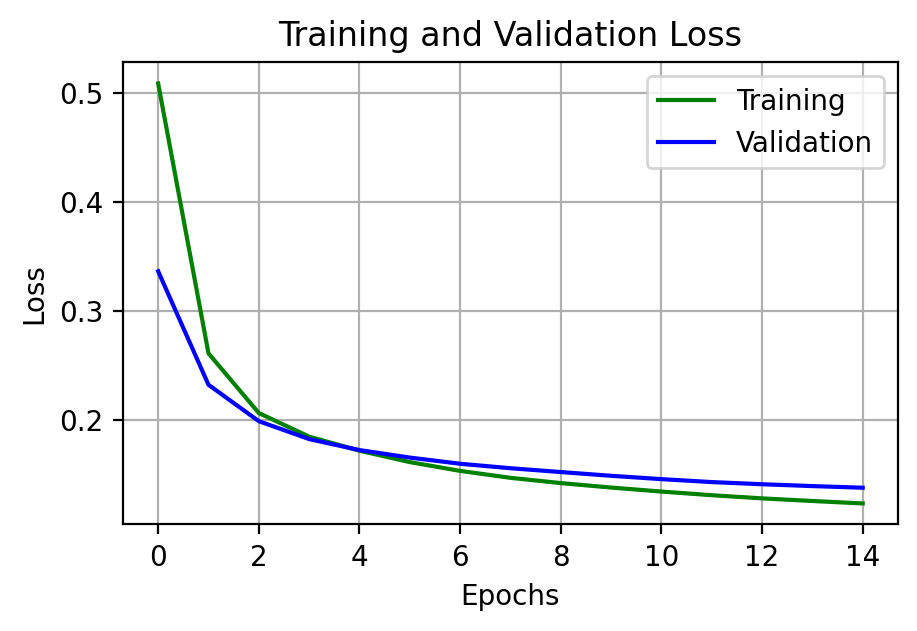

Final Training Loss:   0.12331
Final Validation Loss: 0.137734


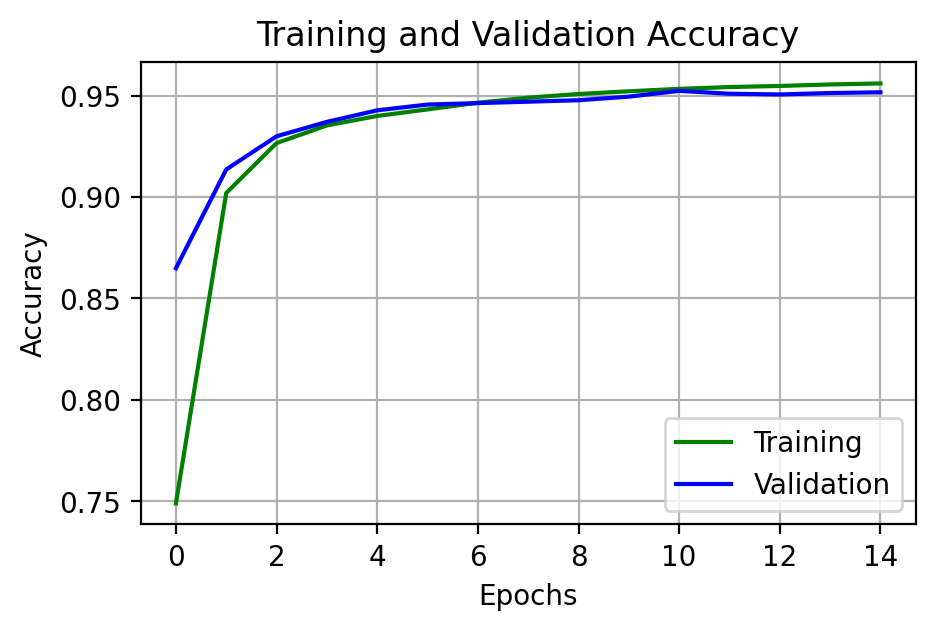

Final Training Accuracy:   0.95602
Final Validation Accuracy: 0.951653

Test Accuracy: 0.9559502664298402



In [90]:
show_performance_curves(history["train_loss"], history["val_loss"],
                        history["train_accuracy"], history["val_accuracy"],
                        test_accuracy)

I experimented with different optimizers like SGD, but ended up using Adam since it lead to better performance. I chose a typical earning rate of 1e-3 and found it to work the best. I tried batch sizes of 32, 64, and 128 but found that 64 worked the best since it provided the greatest balance of accuracy and speed (batch/s). With these experiments I achieved a test accuracy of around 95%. The loss curve also indicates a good fit. If I were to experiment further, I would explore more metrics like precision, NPV, recall, and specifity while considering any class imbalances (although there wasn't a significant class imbalance in this case).